In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset


Dataset Class from CSV

In [124]:
#torch data set
class dataSetAll(Dataset):
    def __init__(self, yearLow, yearHigh):
        #import data from CDC
        self.df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
        self.df = self.df[(yearLow <= self.df["YEAR"]) & (self.df["YEAR"] < yearHigh)]
        #turn data into features and output
        #features: 5 previous + one from last year for predicted
        #output: prediction for next time

        #create test data
        numFeat = 5 #------------------------
        self.X = np.empty([numFeat,len(self.df)-numFeat],dtype=np.float32)
        self.Y = np.empty([1,len(self.df)-numFeat],dtype=np.float32)
        for i in range(self.Y.shape[1]):
            self.X[:,i] = np.asarray(self.df.iloc[i:i+numFeat]["TOTAL"])
            self.Y[:,i] = self.df.iloc[[i+numFeat]]["TOTAL"]

        self.X = torch.from_numpy(self.X)
        self.Y = torch.from_numpy(self.Y)

    def __len__(self):
        return self.Y.shape[1]
    
    def __getitem__(self,idx):
        return self.X[:,idx].T, self.Y[:,idx]

Initialize test and train dataloaders

In [125]:
#create data loaders
train_data = dataSetAll(1900,2013)
test_data = dataSetAll(2013,2100)
train_dataloader = DataLoader(train_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

Create Neural Network Autoregression class

In [126]:
# create neural netowrk
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(5, 40),
            nn.ReLU(),
            nn.Linear(40, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

Create train and tet loops

In [127]:
#train/test loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # print(pred)
        # print(y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % size == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # print(X)
            pred = model(X)
            # print(pred)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\nAvg loss: {test_loss:>8f} \n")

Train the network

In [128]:
learning_rate = .000000001
batch_size = 64
epochs = 1000
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# print(list(model.parameters()))
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

print("Done!")
# print(list(model.parameters()))

loss: 6193424.500000  [    0/  788]
Test Error:
Avg loss: 24135234.208333 

loss: 1503950.375000  [    0/  788]
Test Error:
Avg loss: 18440359.437500 

loss: 1178141.375000  [    0/  788]
Test Error:
Avg loss: 14463060.708333 

loss: 952187.750000  [    0/  788]
Test Error:
Avg loss: 11666299.604167 

loss: 793153.750000  [    0/  788]
Test Error:
Avg loss: 9727037.156250 

loss: 678885.250000  [    0/  788]
Test Error:
Avg loss: 8376325.239583 

loss: 597424.562500  [    0/  788]
Test Error:
Avg loss: 7408526.833333 

loss: 537852.937500  [    0/  788]
Test Error:
Avg loss: 6700817.791667 

loss: 494011.968750  [    0/  788]
Test Error:
Avg loss: 6182560.640625 

loss: 462232.781250  [    0/  788]
Test Error:
Avg loss: 5784464.437500 

loss: 438479.687500  [    0/  788]
Test Error:
Avg loss: 5480807.416667 

loss: 420385.187500  [    0/  788]
Test Error:
Avg loss: 5241755.197917 

loss: 406160.062500  [    0/  788]
Test Error:
Avg loss: 5049466.026042 

loss: 394724.531250  [    0/  7

[[19673. 22224. 20931. 18668. 16228.]]
[[15142.426]]
[[14491.]]


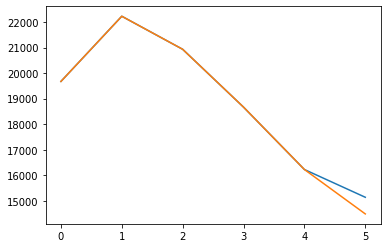

[[22224. 20931. 18668. 16228. 14491.]]
[[14064.26]]
[[12691.]]


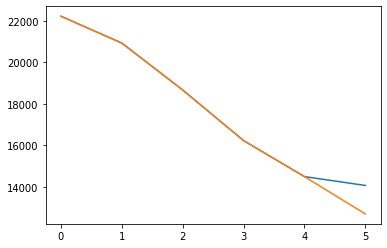

[[20931. 18668. 16228. 14491. 12691.]]
[[12359.361]]
[[11354.]]


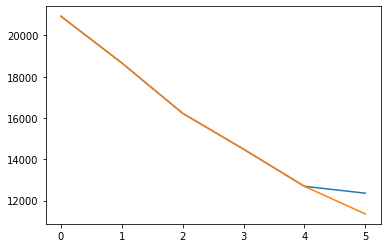

[[18668. 16228. 14491. 12691. 11354.]]
[[11191.061]]
[[10504.]]


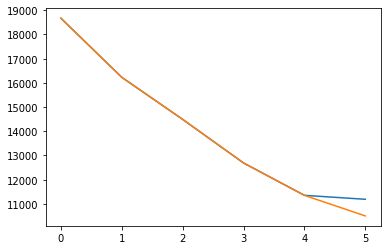

[[16228. 14491. 12691. 11354. 10504.]]
[[10563.702]]
[[10165.]]


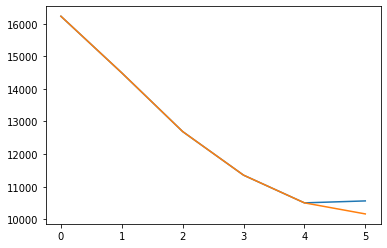

[[14491. 12691. 11354. 10504. 10165.]]
[[10552.197]]
[[9559.]]


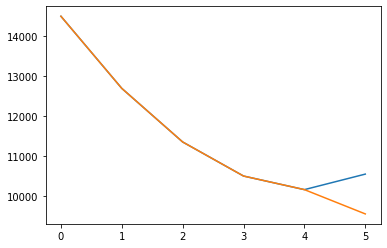

[[12691. 11354. 10504. 10165.  9559.]]
[[9803.225]]
[[8647.]]


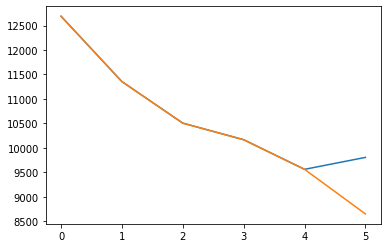

[[11354. 10504. 10165.  9559.  8647.]]
[[8581.795]]
[[7722.]]


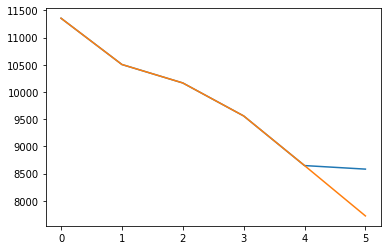

[[10504. 10165.  9559.  8647.  7722.]]
[[7510.235]]
[[6782.]]


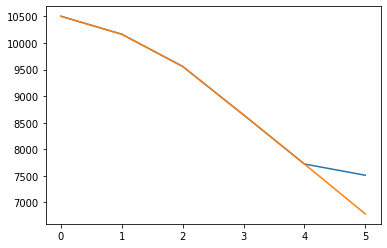

[[10165.  9559.  8647.  7722.  6782.]]
[[6548.041]]
[[6198.]]


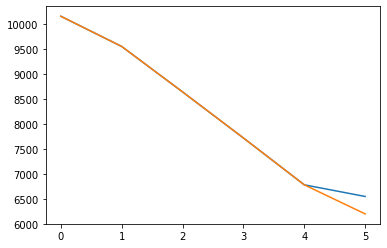

[[9559. 8647. 7722. 6782. 6198.]]
[[6150.76]]
[[5575.]]


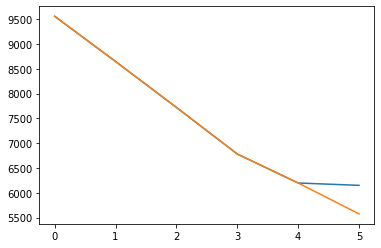

[[8647. 7722. 6782. 6198. 5575.]]
[[5537.171]]
[[5095.]]


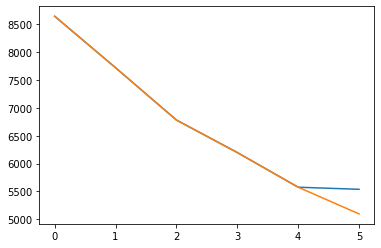

[[7722. 6782. 6198. 5575. 5095.]]
[[5095.5894]]
[[4919.]]


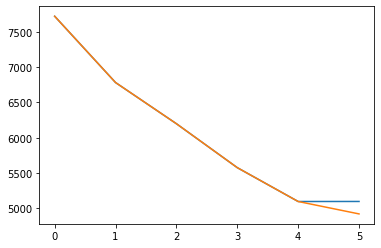

[[6782. 6198. 5575. 5095. 4919.]]
[[5059.991]]
[[4473.]]


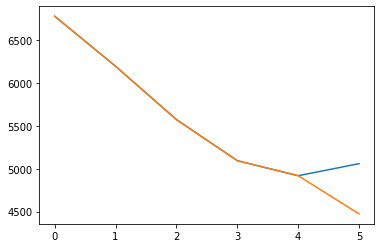

[[6198. 5575. 5095. 4919. 4473.]]
[[4500.9346]]
[[4102.]]


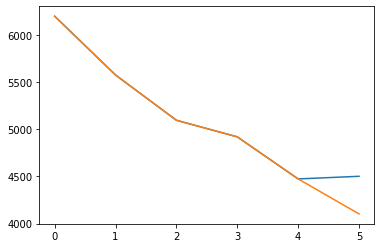

[[5575. 5095. 4919. 4473. 4102.]]
[[4085.4866]]
[[4097.]]


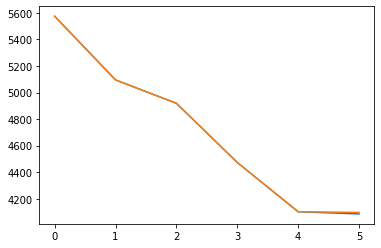

[[5095. 4919. 4473. 4102. 4097.]]
[[4261.193]]
[[3587.]]


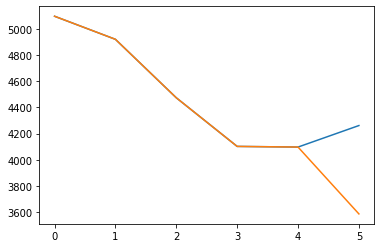

[[4919. 4473. 4102. 4097. 3587.]]
[[3546.2073]]
[[3576.]]


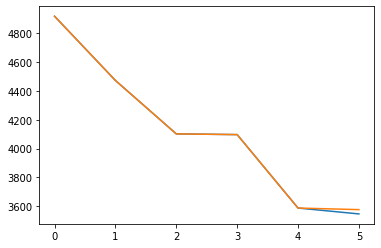

[[4473. 4102. 4097. 3587. 3576.]]
[[3697.6611]]
[[3254.]]


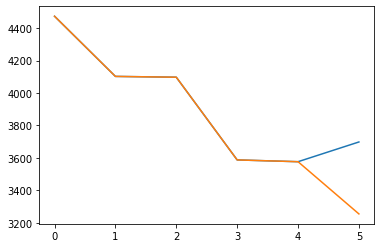

[[4102. 4097. 3587. 3576. 3254.]]
[[3254.4185]]
[[3227.]]


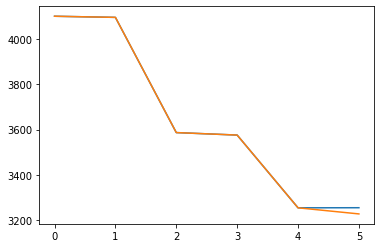

In [129]:
with torch.no_grad():
    model.eval()
    for i in range(20):
        feat = test_data[i:i+1][0].numpy()
        pred = model(test_data[i:i+1][0]).numpy()
        act = test_data[i:i+1][1].numpy()
        print(feat)
        print(pred)
        print(act)
        plt.plot(np.append(feat,pred))
        plt.plot(np.append(feat,act))
        plt.show()
